<a href="https://colab.research.google.com/github/DangLeUyen/Computer-Vision-From-Scratch/blob/main/flowers_classification_AlexNet_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 flowers classification using AlexNet.

The following code is based on the book **Practical Machine Learning for Computer Vision** by Valliappa Lakshmanan, Martin Gorner, and Ryan Gillard.

- *Convolutional Network*: works by sliding a small window (convolutional filter) across the image to extract spatial features.
- *Convolutional Filter*:
  - **\# of Learnable weights = filter_width * filter_height * \# of channels**
  - For example: $4 \times 4$ filter for color images will have 4 * 4 * 3 = 48 learnable weights in total.
- *Convolutional layer*: contains tens of hundreds of similar filters, each with its own independent learable parameters -> output is a multichannel set of 2D values.
  
  $W[4, 4, 3, 5]$ means filter size is (4, 4), \# of channels is 3, and \# of filters is 5
  -> Output: Conv 4,4,5

  The total learnable parameters: 4 * 4 * 3 * 5=240.
- *Pooling layer*: reduces spatial size and computation. Max Pooling (only the maximum value is retained for each group) is the most common type. Others are Average Pooling, Global Pooling. Benefits of pooling:
  - Downsamples feature maps.
  - Introduces spatial invariance.
  - Reduces parameters.
- *Stride*: the number of pixels the filter moves at each step when sliding across the image. stride = 2 means the filter shifts 2 pixels at a time horizontally (and vertically).
- *Padding*: how the input borders are handled when applying a convolution. If padding is 'valid', no padding is added. If padding is 'same', zero-padding is added so the output has the same height and width as the input (for stride = 1).

**Note: Inputs and Outputs of convolutional layers are 4D tensors [batch_size, height, width, channels]**

Example: a batch of 16 color (RGB) images of $256 \times 256$ pixels is a tensor [16, 256, 256, 3]

- *Activation*: a function applied to the weighted sum of the inputs to a node, making neuron network nonlinear. Common activation functions include Sigmoid, ReLU, leakyReLU.
  - $\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}$
  - $\text{ReLU} = \max(0, x)$
  - $\text{LeakyReLU} = \max(0.1x, x)$
- *Softmax*: a special activation function used as the last step in multiclass classifiers. It normalizes the vector to have a sum of 1 so that it can be interpreted as a vector of probabilities.
- *Dropout*: randomly "drop" (i.e set to zero) a fraction of neurons in a layer at each forward pass. Dropout is only applied during training.
- *Batch Normalization*: normalizes activations in intermediate layes to zero mean and unit variance (mean = 0, variance = 1).
- *Early Stopping*: stops training when the model starts to overfit.
- *Epoch*: a full pass through the training dataset during training.

## AlexNet (2012) by Alex Krizhevsky et al.
is a mix of convolutional layers and max-pooling layers.

The AlexNet architecture:

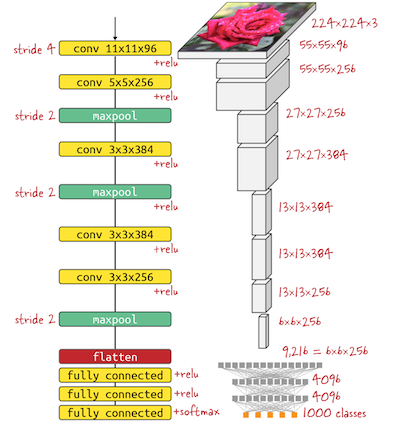

### Import necessary libraries

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.core import history
import PIL
import pathlib

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Common functions

In [22]:
def train(train_dataset, validation_dataset, model, early_stopping=False, num_epochs=10):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

  callbacks = []

  if early_stopping:
      callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))

  history = model.fit(train_dataset,
              validation_data = validation_dataset,
              epochs = num_epochs,
              callbacks = callbacks
              )
  return history

def plot_results(history):
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label = 'validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()



### Load datasets

In [23]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)


In [24]:
data_dir = pathlib.Path(data_dir)
list(data_dir.glob('flower_photos/*/*.jpg'))[:5]


[PosixPath('datasets/flower_photos/flower_photos/roses/5050969148_a0090f762a.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/13235124703_a7e1266e44.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/16157873719_bf0bdf8558_n.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/7285188160_49d84b95a3_m.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/17702388233_f29dc14834_m.jpg')]

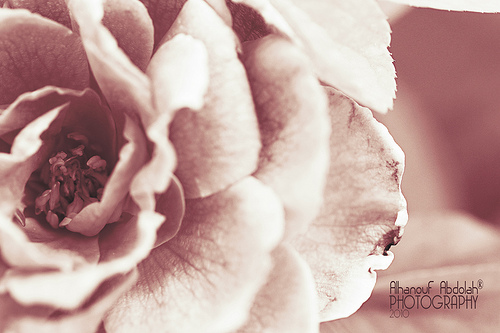

In [25]:

roses = list(data_dir.glob('flower_photos/roses/*'))
PIL.Image.open(str(roses[0]))


In [26]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 15

data_dir = pathlib.Path('datasets/flower_photos/flower_photos')

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

CLASS_NAMES = train_dataset.class_names
print("Classes:", CLASS_NAMES)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)


### Training a AlexNet

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.2329 - loss: 17.5888 - val_accuracy: 0.2425 - val_loss: 1.6087
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.2593 - loss: 1.5993 - val_accuracy: 0.2398 - val_loss: 1.6032
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.2562 - loss: 1.5951 - val_accuracy: 0.2411 - val_loss: 1.6040
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.2555 - loss: 1.5935 - val_accuracy: 0.2725 - val_loss: 1.5755
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.2653 - loss: 1.5903 - val_accuracy: 0.2670 - val_loss: 1.5985
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.2620 - loss: 1.5927 - val_accuracy: 0.2643 - val_loss: 1.5685
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.2681 - loss: 1.5677 - val_accuracy: 0.2629 - val_loss: 1.5869
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.2994 - loss: 1.5393 - val_accuracy: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 50, 50, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 23, 23, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 11, 11, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 9, 9, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,970,833 (343.21 MB)

 Trainable params: 29,990,277 (114.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,980,556 (228.81 MB)

None


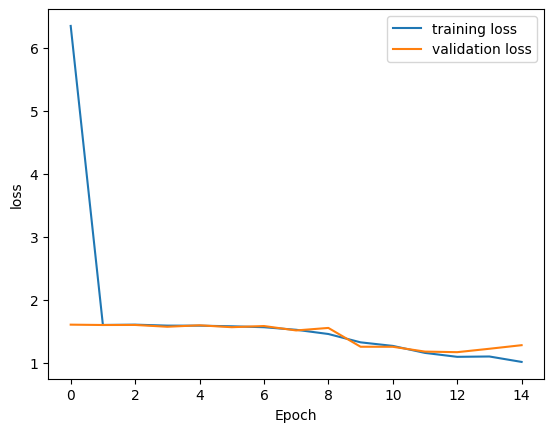

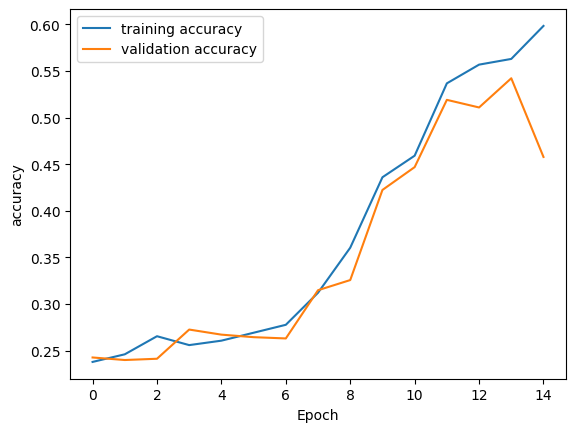

In [28]:
AlexNet_model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
  tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
  tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

AlexNet_history = train(train_dataset, val_dataset, AlexNet_model, num_epochs=NUM_EPOCHS)
print(AlexNet_model.summary())
plot_results(AlexNet_history)
